In [1]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
#data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new = add_category_counts(data_new)

In [9]:
data_new.shape

(95674, 78)

In [10]:
def fineline_dummies(data):
    values = data.FinelineNumber
    counts = values.value_counts()
    mask = values.isin(counts[counts > 500].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [11]:
start = datetime.now()
fln_dummies = fineline_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:18.910371'

In [12]:
data_new = data_new.join(fln_dummies)

In [13]:
data_new.shape

(95674, 351)

In [14]:
def Upc_dummies(data):
    values = data.Upc
    counts = values.value_counts()
    mask = values.isin(counts[counts > 300].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['upc_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [15]:
start = datetime.now()
upc_dummies = Upc_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:06.758646'

In [16]:
data_new = data_new.join(upc_dummies)

In [17]:
data_new.shape

(95674, 451)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [19]:
X = data_new.drop('TripType', axis=1)

trip_types = sorted(data_train.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_new.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
len(X.columns)

450

In [21]:
def create_model_2hl(nodes_l1=512, nodes_l2=128, dropout_l1=0.3, dropout_l2=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [22]:
model_2hl = KerasClassifier(build_fn=create_model_2hl, epochs=100, batch_size=1000, verbose=2)

In [23]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [24]:
start = datetime.now()
hist_2hl = model_2hl.fit(X, y, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

W0911 00:37:56.967412 12748 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0911 00:37:58.576237 12748 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 00:37:58.907596 12748 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0911 00:37:59.053199 12748 depre

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 12s - loss: 1.9432 - acc: 0.4980 - val_loss: 1.1862 - val_acc: 0.6672
Epoch 2/100
 - 8s - loss: 1.1716 - acc: 0.6561 - val_loss: 0.9797 - val_acc: 0.6983
Epoch 3/100
 - 8s - loss: 1.0325 - acc: 0.6786 - val_loss: 0.9140 - val_acc: 0.7092
Epoch 4/100
 - 8s - loss: 0.9623 - acc: 0.6919 - val_loss: 0.8864 - val_acc: 0.7107
Epoch 5/100
 - 8s - loss: 0.9200 - acc: 0.7022 - val_loss: 0.8526 - val_acc: 0.7170
Epoch 6/100
 - 8s - loss: 0.8833 - acc: 0.7098 - val_loss: 0.8484 - val_acc: 0.7190
Epoch 7/100
 - 8s - loss: 0.8567 - acc: 0.7160 - val_loss: 0.8333 - val_acc: 0.7187
Epoch 8/100
 - 8s - loss: 0.8333 - acc: 0.7222 - val_loss: 0.8131 - val_acc: 0.7275
Epoch 9/100
 - 8s - loss: 0.8098 - acc: 0.7281 - val_loss: 0.8107 - val_acc: 0.7254
Epoch 10/100
 - 7s - loss: 0.7952 - acc: 0.7316 - val_loss: 0.8162 - val_acc: 0.7219
Epoch 11/100
 - 8s - loss: 0.7770 - acc: 0.7381 - val_loss: 0.8052 - val_acc: 0.7300
Epoch 12/100
 - 7s - lo

'0:06:59.811279'

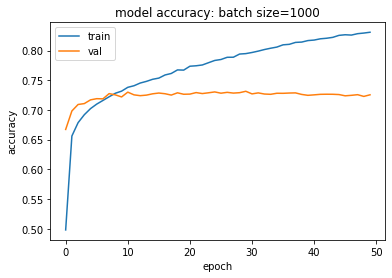

In [25]:
plt.plot(hist_2hl.history['acc'])
plt.plot(hist_2hl.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

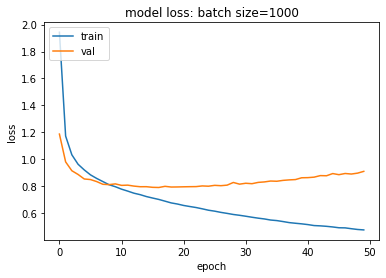

In [26]:
plt.plot(hist_2hl.history['loss'])
plt.plot(hist_2hl.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
scoring = ['accuracy', 'neg_log_loss']
cv = StratifiedKFold(n_splits=4)

In [28]:
nn_2hl = KerasClassifier(build_fn=create_model_2hl, epochs=20, batch_size=1000, verbose=2)

In [29]:
start = datetime.now()
hist_cross_val = cross_validate(nn_2hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 9s - loss: 1.9715 - acc: 0.4894
Epoch 2/20
 - 8s - loss: 1.1839 - acc: 0.6543
Epoch 3/20
 - 8s - loss: 1.0359 - acc: 0.6787
Epoch 4/20
 - 8s - loss: 0.9631 - acc: 0.6929
Epoch 5/20
 - 8s - loss: 0.9175 - acc: 0.7056
Epoch 6/20
 - 7s - loss: 0.8845 - acc: 0.7115
Epoch 7/20
 - 8s - loss: 0.8541 - acc: 0.7171
Epoch 8/20
 - 7s - loss: 0.8318 - acc: 0.7225
Epoch 9/20
 - 7s - loss: 0.8104 - acc: 0.7290
Epoch 10/20
 - 7s - loss: 0.7938 - acc: 0.7337
Epoch 11/20
 - 7s - loss: 0.7790 - acc: 0.7383
Epoch 12/20
 - 8s - loss: 0.7620 - acc: 0.7416
Epoch 13/20
 - 7s - loss: 0.7462 - acc: 0.7459
Epoch 14/20
 - 7s - loss: 0.7376 - acc: 0.7472
Epoch 15/20
 - 7s - loss: 0.7213 - acc: 0.7539
Epoch 16/20
 - 7s - loss: 0.7114 - acc: 0.7548
Epoch 17/20
 - 7s - loss: 0.7020 - acc: 0.7572
Epoch 18/20
 - 8s - loss: 0.6907 - acc: 0.7608
Epoch 19/20
 - 7s - loss: 0.6780 - acc: 0.7657
Epoch 20/20
 - 7s - loss: 0.6647 - acc: 0.7699


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 8s - loss: 1.9845 - acc: 0.4885
Epoch 2/20
 - 9s - loss: 1.1845 - acc: 0.6536
Epoch 3/20
 - 7s - loss: 1.0357 - acc: 0.6811
Epoch 4/20
 - 7s - loss: 0.9640 - acc: 0.6955
Epoch 5/20
 - 7s - loss: 0.9198 - acc: 0.7041
Epoch 6/20
 - 7s - loss: 0.8854 - acc: 0.7106
Epoch 7/20
 - 7s - loss: 0.8585 - acc: 0.7164
Epoch 8/20
 - 7s - loss: 0.8355 - acc: 0.7240
Epoch 9/20
 - 7s - loss: 0.8144 - acc: 0.7283
Epoch 10/20
 - 7s - loss: 0.7980 - acc: 0.7322
Epoch 11/20
 - 7s - loss: 0.7813 - acc: 0.7369
Epoch 12/20
 - 7s - loss: 0.7650 - acc: 0.7409
Epoch 13/20
 - 7s - loss: 0.7504 - acc: 0.7445
Epoch 14/20
 - 8s - loss: 0.7385 - acc: 0.7472
Epoch 15/20
 - 7s - loss: 0.7273 - acc: 0.7524
Epoch 16/20
 - 7s - loss: 0.7122 - acc: 0.7550
Epoch 17/20
 - 7s - loss: 0.6992 - acc: 0.7588
Epoch 18/20
 - 7s - loss: 0.6906 - acc: 0.7606
Epoch 19/20
 - 7s - loss: 0.6819 - acc: 0.7637
Epoch 20/20
 - 7s - loss: 0.6697 - acc: 0.7694


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 7s - loss: 1.9513 - acc: 0.5069
Epoch 2/20
 - 7s - loss: 1.1703 - acc: 0.6580
Epoch 3/20
 - 7s - loss: 1.0200 - acc: 0.6862
Epoch 4/20
 - 7s - loss: 0.9488 - acc: 0.6992
Epoch 5/20
 - 7s - loss: 0.9015 - acc: 0.7090
Epoch 6/20
 - 7s - loss: 0.8667 - acc: 0.7169
Epoch 7/20
 - 7s - loss: 0.8395 - acc: 0.7219
Epoch 8/20
 - 7s - loss: 0.8117 - acc: 0.7301
Epoch 9/20
 - 8s - loss: 0.7979 - acc: 0.7333
Epoch 10/20
 - 7s - loss: 0.7804 - acc: 0.7387
Epoch 11/20
 - 7s - loss: 0.7627 - acc: 0.7442
Epoch 12/20
 - 9s - loss: 0.7441 - acc: 0.7468
Epoch 13/20
 - 8s - loss: 0.7335 - acc: 0.7494
Epoch 14/20
 - 7s - loss: 0.7194 - acc: 0.7534
Epoch 15/20
 - 11s - loss: 0.7069 - acc: 0.7575
Epoch 16/20
 - 9s - loss: 0.6977 - acc: 0.7611
Epoch 17/20
 - 10s - loss: 0.6856 - acc: 0.7614
Epoch 18/20
 - 8s - loss: 0.6721 - acc: 0.7676
Epoch 19/20
 - 8s - loss: 0.6624 - acc: 0.7688
Epoch 20/20
 - 9s - loss: 0.6539 - acc: 0.7727


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 8s - loss: 1.9595 - acc: 0.4984
Epoch 2/20
 - 7s - loss: 1.1859 - acc: 0.6536
Epoch 3/20
 - 7s - loss: 1.0333 - acc: 0.6799
Epoch 4/20
 - 7s - loss: 0.9651 - acc: 0.6935
Epoch 5/20
 - 7s - loss: 0.9177 - acc: 0.7048
Epoch 6/20
 - 7s - loss: 0.8810 - acc: 0.7108
Epoch 7/20
 - 8s - loss: 0.8562 - acc: 0.7170
Epoch 8/20
 - 7s - loss: 0.8324 - acc: 0.7227
Epoch 9/20
 - 7s - loss: 0.8143 - acc: 0.7274
Epoch 10/20
 - 7s - loss: 0.7942 - acc: 0.7327
Epoch 11/20
 - 7s - loss: 0.7761 - acc: 0.7372
Epoch 12/20
 - 7s - loss: 0.7654 - acc: 0.7395
Epoch 13/20
 - 7s - loss: 0.7466 - acc: 0.7460
Epoch 14/20
 - 7s - loss: 0.7394 - acc: 0.7470
Epoch 15/20
 - 7s - loss: 0.7226 - acc: 0.7523
Epoch 16/20
 - 7s - loss: 0.7127 - acc: 0.7544
Epoch 17/20
 - 7s - loss: 0.6979 - acc: 0.7600
Epoch 18/20
 - 7s - loss: 0.6904 - acc: 0.7596
Epoch 19/20
 - 7s - loss: 0.6787 - acc: 0.7643
Epoch 20/20
 - 7s - loss: 0.6705 - acc: 0.7652


'0:09:56.896955'

In [30]:
hist_cross_val

{'fit_time': array([148.16743779, 141.11721659, 157.36728048, 140.71090937]),
 'score_time': array([2.28163695, 2.28758931, 2.43350124, 2.32650757]),
 'test_accuracy': array([0.72669536, 0.72584758, 0.71531321, 0.72638668]),
 'test_neg_log_loss': array([-0.80170125, -0.80467751, -0.85229934, -0.80976613])}

In [31]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7235607065796017, -0.8171110548636173)

In [32]:
nn_2hl = KerasClassifier(build_fn=create_model_2hl, epochs=25, batch_size=1000, verbose=2)

In [33]:
start = datetime.now()
hist_cross_val = cross_validate(nn_2hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/25
 - 8s - loss: 1.9484 - acc: 0.5022
Epoch 2/25
 - 8s - loss: 1.1805 - acc: 0.6552
Epoch 3/25
 - 7s - loss: 1.0320 - acc: 0.6821
Epoch 4/25
 - 9s - loss: 0.9615 - acc: 0.6938
Epoch 5/25
 - 7s - loss: 0.9142 - acc: 0.7056
Epoch 6/25
 - 9s - loss: 0.8837 - acc: 0.7107
Epoch 7/25
 - 8s - loss: 0.8526 - acc: 0.7195
Epoch 8/25
 - 8s - loss: 0.8311 - acc: 0.7244
Epoch 9/25
 - 7s - loss: 0.8100 - acc: 0.7283
Epoch 10/25
 - 8s - loss: 0.7949 - acc: 0.7351
Epoch 11/25
 - 8s - loss: 0.7758 - acc: 0.7373
Epoch 12/25
 - 10s - loss: 0.7601 - acc: 0.7414
Epoch 13/25
 - 7s - loss: 0.7450 - acc: 0.7464
Epoch 14/25
 - 7s - loss: 0.7306 - acc: 0.7514
Epoch 15/25
 - 7s - loss: 0.7214 - acc: 0.7537
Epoch 16/25
 - 8s - loss: 0.7067 - acc: 0.7571
Epoch 17/25
 - 8s - loss: 0.6965 - acc: 0.7598
Epoch 18/25
 - 8s - loss: 0.6847 - acc: 0.7627
Epoch 19/25
 - 8s - loss: 0.6724 - acc: 0.7668
Epoch 20/25
 - 8s - loss: 0.6631 - acc: 0.7692
Epoch 21/25
 - 8s - loss: 0.6551 - acc: 0.7721
Epoch 22/25
 - 8s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/25
 - 10s - loss: 1.9285 - acc: 0.5031
Epoch 2/25
 - 7s - loss: 1.1707 - acc: 0.6569
Epoch 3/25
 - 7s - loss: 1.0339 - acc: 0.6817
Epoch 4/25
 - 8s - loss: 0.9620 - acc: 0.6949
Epoch 5/25
 - 8s - loss: 0.9175 - acc: 0.7054
Epoch 6/25
 - 7s - loss: 0.8824 - acc: 0.7127
Epoch 7/25
 - 8s - loss: 0.8543 - acc: 0.7191
Epoch 8/25
 - 7s - loss: 0.8326 - acc: 0.7240
Epoch 9/25
 - 9s - loss: 0.8118 - acc: 0.7299
Epoch 10/25
 - 7s - loss: 0.7946 - acc: 0.7333
Epoch 11/25
 - 8s - loss: 0.7816 - acc: 0.7371
Epoch 12/25
 - 7s - loss: 0.7597 - acc: 0.7433
Epoch 13/25
 - 7s - loss: 0.7498 - acc: 0.7450
Epoch 14/25
 - 7s - loss: 0.7332 - acc: 0.7496
Epoch 15/25
 - 8s - loss: 0.7239 - acc: 0.7534
Epoch 16/25
 - 7s - loss: 0.7107 - acc: 0.7558
Epoch 17/25
 - 8s - loss: 0.6967 - acc: 0.7610
Epoch 18/25
 - 8s - loss: 0.6853 - acc: 0.7611
Epoch 19/25
 - 7s - loss: 0.6776 - acc: 0.7669
Epoch 20/25
 - 7s - loss: 0.6690 - acc: 0.7687
Epoch 21/25
 - 7s - loss: 0.6537 - acc: 0.7729
Epoch 22/25
 - 7s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/25
 - 8s - loss: 1.9322 - acc: 0.5011
Epoch 2/25
 - 7s - loss: 1.1624 - acc: 0.6600
Epoch 3/25
 - 8s - loss: 1.0145 - acc: 0.6858
Epoch 4/25
 - 7s - loss: 0.9428 - acc: 0.6995
Epoch 5/25
 - 8s - loss: 0.8987 - acc: 0.7087
Epoch 6/25
 - 8s - loss: 0.8644 - acc: 0.7169
Epoch 7/25
 - 7s - loss: 0.8381 - acc: 0.7231
Epoch 8/25
 - 7s - loss: 0.8167 - acc: 0.7278
Epoch 9/25
 - 7s - loss: 0.7917 - acc: 0.7350
Epoch 10/25
 - 8s - loss: 0.7821 - acc: 0.7368
Epoch 11/25
 - 7s - loss: 0.7636 - acc: 0.7420
Epoch 12/25
 - 7s - loss: 0.7478 - acc: 0.7449
Epoch 13/25
 - 7s - loss: 0.7349 - acc: 0.7482
Epoch 14/25
 - 8s - loss: 0.7200 - acc: 0.7552
Epoch 15/25
 - 7s - loss: 0.7049 - acc: 0.7592
Epoch 16/25
 - 7s - loss: 0.6941 - acc: 0.7613
Epoch 17/25
 - 7s - loss: 0.6843 - acc: 0.7645
Epoch 18/25
 - 7s - loss: 0.6749 - acc: 0.7662
Epoch 19/25
 - 8s - loss: 0.6591 - acc: 0.7706
Epoch 20/25
 - 8s - loss: 0.6528 - acc: 0.7730
Epoch 21/25
 - 8s - loss: 0.6428 - acc: 0.7767
Epoch 22/25
 - 7s - lo

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/25
 - 9s - loss: 1.9586 - acc: 0.4996
Epoch 2/25
 - 10s - loss: 1.1842 - acc: 0.6526
Epoch 3/25
 - 10s - loss: 1.0388 - acc: 0.6791
Epoch 4/25
 - 7s - loss: 0.9647 - acc: 0.6935
Epoch 5/25
 - 8s - loss: 0.9234 - acc: 0.7012
Epoch 6/25
 - 7s - loss: 0.8846 - acc: 0.7095
Epoch 7/25
 - 8s - loss: 0.8565 - acc: 0.7169
Epoch 8/25
 - 7s - loss: 0.8354 - acc: 0.7214
Epoch 9/25
 - 8s - loss: 0.8151 - acc: 0.7270
Epoch 10/25
 - 8s - loss: 0.7976 - acc: 0.7319
Epoch 11/25
 - 7s - loss: 0.7788 - acc: 0.7373
Epoch 12/25
 - 7s - loss: 0.7631 - acc: 0.7419
Epoch 13/25
 - 7s - loss: 0.7482 - acc: 0.7449
Epoch 14/25
 - 7s - loss: 0.7378 - acc: 0.7483
Epoch 15/25
 - 7s - loss: 0.7246 - acc: 0.7528
Epoch 16/25
 - 8s - loss: 0.7115 - acc: 0.7569
Epoch 17/25
 - 7s - loss: 0.6998 - acc: 0.7599
Epoch 18/25
 - 7s - loss: 0.6893 - acc: 0.7623
Epoch 19/25
 - 7s - loss: 0.6782 - acc: 0.7638
Epoch 20/25
 - 7s - loss: 0.6699 - acc: 0.7692
Epoch 21/25
 - 8s - loss: 0.6550 - acc: 0.7720
Epoch 22/25
 - 7s - 

'0:12:48.127506'

In [34]:
hist_cross_val

{'fit_time': array([196.83171916, 188.92661357, 183.6908927 , 189.82669473]),
 'score_time': array([2.38952923, 2.05273533, 2.00980282, 2.1036973 ]),
 'test_accuracy': array([0.73179292, 0.72760336, 0.71769675, 0.73006777]),
 'test_neg_log_loss': array([-0.80699333, -0.81443609, -0.8712659 , -0.80156985])}

In [35]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7267901987651547, -0.8235662922703799)

In [36]:
def create_model_2hl(nodes_l1=400, nodes_l2=120, dropout_l1=0.3, dropout_l2=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [37]:
start = datetime.now()
hist_2hl_v2= model_2hl.fit(X, y, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 9s - loss: 2.0216 - acc: 0.4917 - val_loss: 1.2107 - val_acc: 0.6562
Epoch 2/100
 - 8s - loss: 1.1979 - acc: 0.6509 - val_loss: 0.9838 - val_acc: 0.6973
Epoch 3/100
 - 8s - loss: 1.0350 - acc: 0.6821 - val_loss: 0.9111 - val_acc: 0.7099
Epoch 4/100
 - 8s - loss: 0.9687 - acc: 0.6927 - val_loss: 0.8817 - val_acc: 0.7107
Epoch 5/100
 - 10s - loss: 0.9193 - acc: 0.7030 - val_loss: 0.8545 - val_acc: 0.7205
Epoch 6/100
 - 10s - loss: 0.8859 - acc: 0.7099 - val_loss: 0.8398 - val_acc: 0.7235
Epoch 7/100
 - 11s - loss: 0.8592 - acc: 0.7159 - val_loss: 0.8289 - val_acc: 0.7238
Epoch 8/100
 - 9s - loss: 0.8352 - acc: 0.7222 - val_loss: 0.8178 - val_acc: 0.7267
Epoch 9/100
 - 8s - loss: 0.8137 - acc: 0.7284 - val_loss: 0.8118 - val_acc: 0.7269
Epoch 10/100
 - 8s - loss: 0.7965 - acc: 0.7314 - val_loss: 0.8107 - val_acc: 0.7254
Epoch 11/100
 - 8s - loss: 0.7775 - acc: 0.7373 - val_loss: 0.8054 - val_acc: 0.7285
Epoch 12/100
 - 9s - 

'0:05:13.788798'

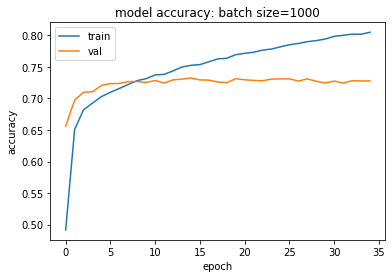

In [38]:
plt.plot(hist_2hl_v2.history['acc'])
plt.plot(hist_2hl_v2.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

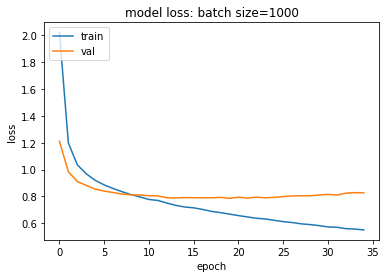

In [39]:
plt.plot(hist_2hl_v2.history['loss'])
plt.plot(hist_2hl_v2.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
nn_2hl = KerasClassifier(build_fn=create_model_2hl, epochs=15, batch_size=1000, verbose=2)

In [42]:
start = datetime.now()
hist_cross_val_v2 = cross_validate(nn_2hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 6s - loss: 2.0882 - acc: 0.4788
Epoch 2/15
 - 6s - loss: 1.2379 - acc: 0.6475
Epoch 3/15
 - 5s - loss: 1.0696 - acc: 0.6758
Epoch 4/15
 - 5s - loss: 0.9900 - acc: 0.6910
Epoch 5/15
 - 6s - loss: 0.9424 - acc: 0.7001
Epoch 6/15
 - 5s - loss: 0.9078 - acc: 0.7069
Epoch 7/15
 - 5s - loss: 0.8821 - acc: 0.7119
Epoch 8/15
 - 5s - loss: 0.8578 - acc: 0.7183
Epoch 9/15
 - 5s - loss: 0.8368 - acc: 0.7230
Epoch 10/15
 - 6s - loss: 0.8216 - acc: 0.7264
Epoch 11/15
 - 7s - loss: 0.8022 - acc: 0.7315
Epoch 12/15
 - 7s - loss: 0.7904 - acc: 0.7335
Epoch 13/15
 - 7s - loss: 0.7773 - acc: 0.7377
Epoch 14/15
 - 6s - loss: 0.7619 - acc: 0.7411
Epoch 15/15
 - 7s - loss: 0.7522 - acc: 0.7436


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 7s - loss: 2.0424 - acc: 0.4852
Epoch 2/15
 - 7s - loss: 1.2235 - acc: 0.6471
Epoch 3/15
 - 7s - loss: 1.0561 - acc: 0.6766
Epoch 4/15
 - 6s - loss: 0.9812 - acc: 0.6932
Epoch 5/15
 - 7s - loss: 0.9357 - acc: 0.7007
Epoch 6/15
 - 6s - loss: 0.8991 - acc: 0.7062
Epoch 7/15
 - 6s - loss: 0.8760 - acc: 0.7148
Epoch 8/15
 - 6s - loss: 0.8505 - acc: 0.7191
Epoch 9/15
 - 6s - loss: 0.8306 - acc: 0.7241
Epoch 10/15
 - 6s - loss: 0.8136 - acc: 0.7280
Epoch 11/15
 - 6s - loss: 0.7964 - acc: 0.7339
Epoch 12/15
 - 6s - loss: 0.7824 - acc: 0.7367
Epoch 13/15
 - 6s - loss: 0.7704 - acc: 0.7392
Epoch 14/15
 - 6s - loss: 0.7572 - acc: 0.7432
Epoch 15/15
 - 7s - loss: 0.7451 - acc: 0.7454


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 7s - loss: 2.0622 - acc: 0.4827
Epoch 2/15
 - 7s - loss: 1.2233 - acc: 0.6490
Epoch 3/15
 - 6s - loss: 1.0504 - acc: 0.6799
Epoch 4/15
 - 7s - loss: 0.9736 - acc: 0.6950
Epoch 5/15
 - 6s - loss: 0.9262 - acc: 0.7040
Epoch 6/15
 - 6s - loss: 0.8941 - acc: 0.7110
Epoch 7/15
 - 6s - loss: 0.8661 - acc: 0.7185
Epoch 8/15
 - 6s - loss: 0.8421 - acc: 0.7234
Epoch 9/15
 - 7s - loss: 0.8212 - acc: 0.7273
Epoch 10/15
 - 6s - loss: 0.8043 - acc: 0.7316
Epoch 11/15
 - 6s - loss: 0.7881 - acc: 0.7363
Epoch 12/15
 - 8s - loss: 0.7761 - acc: 0.7407
Epoch 13/15
 - 6s - loss: 0.7633 - acc: 0.7421
Epoch 14/15
 - 6s - loss: 0.7482 - acc: 0.7471
Epoch 15/15
 - 6s - loss: 0.7362 - acc: 0.7503


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 8s - loss: 2.0219 - acc: 0.4844
Epoch 2/15
 - 6s - loss: 1.2243 - acc: 0.6464
Epoch 3/15
 - 6s - loss: 1.0626 - acc: 0.6752
Epoch 4/15
 - 6s - loss: 0.9884 - acc: 0.6871
Epoch 5/15
 - 6s - loss: 0.9409 - acc: 0.6982
Epoch 6/15
 - 6s - loss: 0.9072 - acc: 0.7063
Epoch 7/15
 - 6s - loss: 0.8744 - acc: 0.7128
Epoch 8/15
 - 6s - loss: 0.8569 - acc: 0.7184
Epoch 9/15
 - 8s - loss: 0.8342 - acc: 0.7235
Epoch 10/15
 - 7s - loss: 0.8181 - acc: 0.7268
Epoch 11/15
 - 8s - loss: 0.8026 - acc: 0.7305
Epoch 12/15
 - 7s - loss: 0.7844 - acc: 0.7371
Epoch 13/15
 - 7s - loss: 0.7734 - acc: 0.7385
Epoch 14/15
 - 7s - loss: 0.7634 - acc: 0.7408
Epoch 15/15
 - 7s - loss: 0.7480 - acc: 0.7460


'0:06:35.494751'

In [43]:
hist_cross_val_v2

{'fit_time': array([ 90.73396873,  96.60047722,  97.37056613, 101.94318676]),
 'score_time': array([2.29858422, 1.91881824, 1.96678734, 2.44549012]),
 'test_accuracy': array([0.72569256, 0.72785419, 0.71410053, 0.73123902]),
 'test_neg_log_loss': array([-0.801276  , -0.80024194, -0.85705825, -0.79371171])}

In [45]:
hist_cross_val_v2['test_accuracy'].mean(), hist_cross_val_v2['test_neg_log_loss'].mean()

(0.7247215728677722, -0.8130719737860261)

In [51]:
def create_model_3hl(nodes_l1=500, nodes_l2=200, nodes_l3=80, dropout_l1=0.3, dropout_l2=0.2, dropout_l3=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [52]:
model_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=100, batch_size=1000, verbose=2)

In [53]:
start = datetime.now()
hist_3hl = model_3hl.fit(X, y, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=500)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 12s - loss: 1.9236 - acc: 0.4849 - val_loss: 1.1581 - val_acc: 0.6648
Epoch 2/100
 - 10s - loss: 1.2160 - acc: 0.6439 - val_loss: 1.0094 - val_acc: 0.6828
Epoch 3/100
 - 10s - loss: 1.0723 - acc: 0.6695 - val_loss: 0.9934 - val_acc: 0.6726
Epoch 4/100
 - 10s - loss: 0.9961 - acc: 0.6863 - val_loss: 0.8911 - val_acc: 0.7133
Epoch 5/100
 - 10s - loss: 0.9498 - acc: 0.6978 - val_loss: 0.8556 - val_acc: 0.7205
Epoch 6/100
 - 10s - loss: 0.9102 - acc: 0.7051 - val_loss: 0.8636 - val_acc: 0.7152
Epoch 7/100
 - 12s - loss: 0.8731 - acc: 0.7130 - val_loss: 0.8834 - val_acc: 0.7087
Epoch 8/100
 - 11s - loss: 0.8515 - acc: 0.7206 - val_loss: 0.8229 - val_acc: 0.7245
Epoch 9/100
 - 10s - loss: 0.8270 - acc: 0.7259 - val_loss: 0.8227 - val_acc: 0.7288
Epoch 10/100
 - 10s - loss: 0.8060 - acc: 0.7305 - val_loss: 0.8037 - val_acc: 0.7323
Epoch 11/100
 - 10s - loss: 0.7853 - acc: 0.7363 - val_loss: 0.8337 - val_acc: 0.7210
Epoch 12/100


'0:08:01.991870'

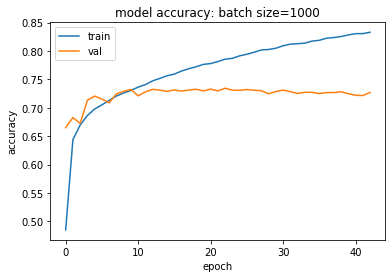

In [54]:
plt.plot(hist_3hl.history['acc'])
plt.plot(hist_3hl.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

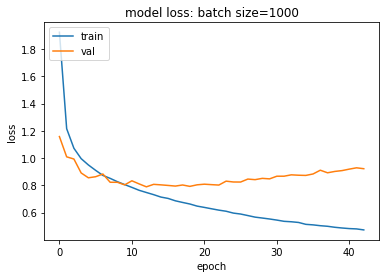

In [55]:
plt.plot(hist_3hl.history['loss'])
plt.plot(hist_3hl.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
nn_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=15, batch_size=1000, verbose=2)

In [72]:
start = datetime.now()
hist_cross_val = cross_validate(nn_3hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
 - 9s - loss: 1.9923 - acc: 0.4699
Epoch 2/15
 - 8s - loss: 1.2457 - acc: 0.6408
Epoch 3/15
 - 7s - loss: 1.0891 - acc: 0.6704
Epoch 4/15
 - 8s - loss: 1.0197 - acc: 0.6804
Epoch 5/15
 - 8s - loss: 0.9664 - acc: 0.6936
Epoch 6/15
 - 8s - loss: 0.9247 - acc: 0.7016
Epoch 7/15
 - 7s - loss: 0.8932 - acc: 0.7103
Epoch 8/15
 - 8s - loss: 0.8682 - acc: 0.7153
Epoch 9/15
 - 7s - loss: 0.8470 - acc: 0.7212
Epoch 10/15
 - 8s - loss: 0.8230 - acc: 0.7269
Epoch 11/15
 - 7s - loss: 0.8029 - acc: 0.7320
Epoch 12/15
 - 7s - loss: 0.7873 - acc: 0.7346
Epoch 13/15
 - 7s - loss: 0.7706 - acc: 0.7401
Epoch 14/15
 - 8s - loss: 0.7556 - acc: 0.7444
Epoch 15/15
 - 7s - loss: 0.7433 - acc: 0.7492


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
 - 10s - loss: 1.9828 - acc: 0.4723
Epoch 2/15
 - 7s - loss: 1.2356 - acc: 0.6413
Epoch 3/15
 - 8s - loss: 1.0875 - acc: 0.6688
Epoch 4/15
 - 7s - loss: 1.0086 - acc: 0.6840
Epoch 5/15
 - 8s - loss: 0.9561 - acc: 0.6954
Epoch 6/15
 - 8s - loss: 0.9215 - acc: 0.7032
Epoch 7/15
 - 8s - loss: 0.8931 - acc: 0.7108
Epoch 8/15
 - 7s - loss: 0.8608 - acc: 0.7182
Epoch 9/15
 - 8s - loss: 0.8377 - acc: 0.7246
Epoch 10/15
 - 8s - loss: 0.8194 - acc: 0.7281
Epoch 11/15
 - 9s - loss: 0.7969 - acc: 0.7347
Epoch 12/15
 - 8s - loss: 0.7829 - acc: 0.7362
Epoch 13/15
 - 9s - loss: 0.7683 - acc: 0.7423
Epoch 14/15
 - 8s - loss: 0.7506 - acc: 0.7469
Epoch 15/15
 - 8s - loss: 0.7339 - acc: 0.7519


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
 - 10s - loss: 1.9337 - acc: 0.4868
Epoch 2/15
 - 10s - loss: 1.2114 - acc: 0.6469
Epoch 3/15
 - 10s - loss: 1.0653 - acc: 0.6748
Epoch 4/15
 - 10s - loss: 0.9893 - acc: 0.6890
Epoch 5/15
 - 10s - loss: 0.9436 - acc: 0.6996
Epoch 6/15
 - 9s - loss: 0.9045 - acc: 0.7096
Epoch 7/15
 - 9s - loss: 0.8721 - acc: 0.7173
Epoch 8/15
 - 10s - loss: 0.8477 - acc: 0.7207
Epoch 9/15
 - 9s - loss: 0.8239 - acc: 0.7280
Epoch 10/15
 - 9s - loss: 0.8001 - acc: 0.7330
Epoch 11/15
 - 9s - loss: 0.7780 - acc: 0.7405
Epoch 12/15
 - 10s - loss: 0.7643 - acc: 0.7436
Epoch 13/15
 - 10s - loss: 0.7498 - acc: 0.7468
Epoch 14/15
 - 9s - loss: 0.7308 - acc: 0.7517
Epoch 15/15
 - 11s - loss: 0.7185 - acc: 0.7544


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
 - 14s - loss: 1.9779 - acc: 0.4729
Epoch 2/15
 - 10s - loss: 1.2444 - acc: 0.6384
Epoch 3/15
 - 10s - loss: 1.0880 - acc: 0.6652
Epoch 4/15
 - 10s - loss: 1.0120 - acc: 0.6825
Epoch 5/15
 - 9s - loss: 0.9651 - acc: 0.6916
Epoch 6/15
 - 8s - loss: 0.9232 - acc: 0.7011
Epoch 7/15
 - 9s - loss: 0.8922 - acc: 0.7091
Epoch 8/15
 - 8s - loss: 0.8707 - acc: 0.7148
Epoch 9/15
 - 9s - loss: 0.8429 - acc: 0.7215
Epoch 10/15
 - 8s - loss: 0.8194 - acc: 0.7269
Epoch 11/15
 - 9s - loss: 0.8027 - acc: 0.7310
Epoch 12/15
 - 8s - loss: 0.7838 - acc: 0.7356
Epoch 13/15
 - 9s - loss: 0.7714 - acc: 0.7401
Epoch 14/15
 - 8s - loss: 0.7557 - acc: 0.7448
Epoch 15/15
 - 8s - loss: 0.7400 - acc: 0.7484


'0:08:55.521134'

In [79]:
hist_cross_val

{'fit_time': array([115.50482845, 121.67103148, 145.03272271, 140.45477915]),
 'score_time': array([2.50245714, 2.54443002, 4.42197394, 3.10708308]),
 'test_accuracy': array([0.73304642, 0.7260566 , 0.71376599, 0.73119719]),
 'test_neg_log_loss': array([-0.80554453, -0.8069721 , -0.87296957, -0.80074112])}

In [74]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7260165520122847, -0.8215568299849783)

In [75]:
nn_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=20, batch_size=1000, verbose=2)

In [76]:
start = datetime.now()
hist_cross_val_v2 = cross_validate(nn_3hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 12s - loss: 1.9604 - acc: 0.4761
Epoch 2/20
 - 9s - loss: 1.2393 - acc: 0.6400
Epoch 3/20
 - 9s - loss: 1.0854 - acc: 0.6685
Epoch 4/20
 - 9s - loss: 1.0131 - acc: 0.6823
Epoch 5/20
 - 9s - loss: 0.9592 - acc: 0.6961
Epoch 6/20
 - 9s - loss: 0.9200 - acc: 0.7030
Epoch 7/20
 - 9s - loss: 0.8922 - acc: 0.7107
Epoch 8/20
 - 9s - loss: 0.8643 - acc: 0.7161
Epoch 9/20
 - 8s - loss: 0.8432 - acc: 0.7206
Epoch 10/20
 - 8s - loss: 0.8187 - acc: 0.7267
Epoch 11/20
 - 9s - loss: 0.8039 - acc: 0.7312
Epoch 12/20
 - 8s - loss: 0.7842 - acc: 0.7383
Epoch 13/20
 - 8s - loss: 0.7690 - acc: 0.7396
Epoch 14/20
 - 8s - loss: 0.7502 - acc: 0.7477
Epoch 15/20
 - 8s - loss: 0.7385 - acc: 0.7513
Epoch 16/20
 - 8s - loss: 0.7247 - acc: 0.7538
Epoch 17/20
 - 8s - loss: 0.7104 - acc: 0.7561
Epoch 18/20
 - 8s - loss: 0.6994 - acc: 0.7581
Epoch 19/20
 - 9s - loss: 0.6890 - acc: 0.7623
Epoch 20/20
 - 8s - loss: 0.6816 - acc: 0.7661


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 11s - loss: 1.9639 - acc: 0.4763
Epoch 2/20
 - 9s - loss: 1.2296 - acc: 0.6398
Epoch 3/20
 - 8s - loss: 1.0843 - acc: 0.6701
Epoch 4/20
 - 8s - loss: 1.0091 - acc: 0.6831
Epoch 5/20
 - 8s - loss: 0.9613 - acc: 0.6945
Epoch 6/20
 - 9s - loss: 0.9229 - acc: 0.7027
Epoch 7/20
 - 8s - loss: 0.8888 - acc: 0.7124
Epoch 8/20
 - 8s - loss: 0.8622 - acc: 0.7161
Epoch 9/20
 - 8s - loss: 0.8406 - acc: 0.7219
Epoch 10/20
 - 8s - loss: 0.8194 - acc: 0.7282
Epoch 11/20
 - 8s - loss: 0.7993 - acc: 0.7320
Epoch 12/20
 - 9s - loss: 0.7833 - acc: 0.7366
Epoch 13/20
 - 8s - loss: 0.7622 - acc: 0.7433
Epoch 14/20
 - 9s - loss: 0.7491 - acc: 0.7458
Epoch 15/20
 - 8s - loss: 0.7339 - acc: 0.7502
Epoch 16/20
 - 8s - loss: 0.7210 - acc: 0.7537
Epoch 17/20
 - 8s - loss: 0.7105 - acc: 0.7582
Epoch 18/20
 - 8s - loss: 0.6975 - acc: 0.7610
Epoch 19/20
 - 8s - loss: 0.6835 - acc: 0.7662
Epoch 20/20
 - 8s - loss: 0.6731 - acc: 0.7662


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 11s - loss: 1.9567 - acc: 0.4772
Epoch 2/20
 - 8s - loss: 1.2138 - acc: 0.6457
Epoch 3/20
 - 8s - loss: 1.0664 - acc: 0.6741
Epoch 4/20
 - 8s - loss: 0.9904 - acc: 0.6884
Epoch 5/20
 - 8s - loss: 0.9426 - acc: 0.7005
Epoch 6/20
 - 8s - loss: 0.9070 - acc: 0.7084
Epoch 7/20
 - 8s - loss: 0.8727 - acc: 0.7151
Epoch 8/20
 - 8s - loss: 0.8523 - acc: 0.7211
Epoch 9/20
 - 8s - loss: 0.8240 - acc: 0.7279
Epoch 10/20
 - 8s - loss: 0.8033 - acc: 0.7324
Epoch 11/20
 - 8s - loss: 0.7857 - acc: 0.7370
Epoch 12/20
 - 8s - loss: 0.7698 - acc: 0.7403
Epoch 13/20
 - 8s - loss: 0.7509 - acc: 0.7467
Epoch 14/20
 - 8s - loss: 0.7347 - acc: 0.7498
Epoch 15/20
 - 8s - loss: 0.7198 - acc: 0.7551
Epoch 16/20
 - 8s - loss: 0.7091 - acc: 0.7584
Epoch 17/20
 - 8s - loss: 0.6954 - acc: 0.7608
Epoch 18/20
 - 8s - loss: 0.6817 - acc: 0.7676
Epoch 19/20
 - 8s - loss: 0.6735 - acc: 0.7681
Epoch 20/20
 - 8s - loss: 0.6638 - acc: 0.7696


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 12s - loss: 1.9845 - acc: 0.4702
Epoch 2/20
 - 8s - loss: 1.2322 - acc: 0.6402
Epoch 3/20
 - 8s - loss: 1.0833 - acc: 0.6694
Epoch 4/20
 - 8s - loss: 1.0081 - acc: 0.6827
Epoch 5/20
 - 8s - loss: 0.9630 - acc: 0.6928
Epoch 6/20
 - 8s - loss: 0.9255 - acc: 0.7026
Epoch 7/20
 - 8s - loss: 0.8951 - acc: 0.7088
Epoch 8/20
 - 8s - loss: 0.8682 - acc: 0.7148
Epoch 9/20
 - 8s - loss: 0.8439 - acc: 0.7212
Epoch 10/20
 - 8s - loss: 0.8255 - acc: 0.7249
Epoch 11/20
 - 8s - loss: 0.8050 - acc: 0.7311
Epoch 12/20
 - 8s - loss: 0.7858 - acc: 0.7362
Epoch 13/20
 - 8s - loss: 0.7750 - acc: 0.7405
Epoch 14/20
 - 8s - loss: 0.7568 - acc: 0.7445
Epoch 15/20
 - 8s - loss: 0.7435 - acc: 0.7490
Epoch 16/20
 - 8s - loss: 0.7317 - acc: 0.7504
Epoch 17/20
 - 8s - loss: 0.7184 - acc: 0.7541
Epoch 18/20
 - 8s - loss: 0.7050 - acc: 0.7590
Epoch 19/20
 - 9s - loss: 0.6935 - acc: 0.7628
Epoch 20/20
 - 8s - loss: 0.6848 - acc: 0.7651


'0:11:18.399518'

In [77]:
hist_cross_val_v2

{'fit_time': array([173.37916923, 167.80360389, 160.93183565, 163.93451738]),
 'score_time': array([2.89721537, 2.83025408, 2.95218229, 3.41689372]),
 'test_accuracy': array([0.72544186, 0.72672547, 0.71497867, 0.73211746]),
 'test_neg_log_loss': array([-0.80503169, -0.80122706, -0.86342535, -0.80422905])}

In [78]:
hist_cross_val_v2['test_accuracy'].mean(), hist_cross_val_v2['test_neg_log_loss'].mean()

(0.7248158658742692, -0.8184782840801821)

In [62]:
def create_model_3hl(nodes_l1=400, nodes_l2=200, nodes_l3=100, dropout_l1=0.3, dropout_l2=0.2, dropout_l3=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [63]:
model_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=100, batch_size=1000, verbose=2)

In [64]:
start = datetime.now()
hist_3hl = model_3hl.fit(X, y, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 15s - loss: 1.9834 - acc: 0.4713 - val_loss: 1.2404 - val_acc: 0.6457
Epoch 2/100
 - 12s - loss: 1.2493 - acc: 0.6376 - val_loss: 1.0411 - val_acc: 0.6808
Epoch 3/100
 - 12s - loss: 1.0966 - acc: 0.6671 - val_loss: 0.9775 - val_acc: 0.6852
Epoch 4/100
 - 11s - loss: 1.0197 - acc: 0.6814 - val_loss: 0.9385 - val_acc: 0.6953
Epoch 5/100
 - 11s - loss: 0.9672 - acc: 0.6938 - val_loss: 0.8770 - val_acc: 0.7153
Epoch 6/100
 - 12s - loss: 0.9294 - acc: 0.7005 - val_loss: 0.8731 - val_acc: 0.7140
Epoch 7/100
 - 12s - loss: 0.8910 - acc: 0.7121 - val_loss: 0.8487 - val_acc: 0.7209
Epoch 8/100
 - 12s - loss: 0.8690 - acc: 0.7152 - val_loss: 0.8302 - val_acc: 0.7217
Epoch 9/100
 - 11s - loss: 0.8479 - acc: 0.7214 - val_loss: 0.8184 - val_acc: 0.7216
Epoch 10/100
 - 12s - loss: 0.8255 - acc: 0.7263 - val_loss: 0.8121 - val_acc: 0.7288
Epoch 11/100
 - 12s - loss: 0.8063 - acc: 0.7313 - val_loss: 0.8085 - val_acc: 0.7314
Epoch 12/100


'0:08:54.747503'

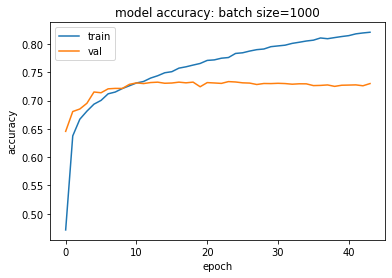

In [65]:
plt.plot(hist_3hl.history['acc'])
plt.plot(hist_3hl.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

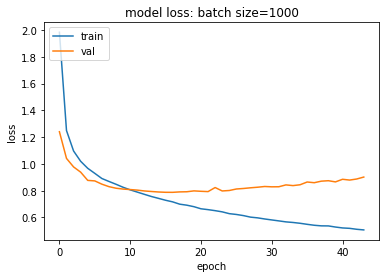

In [66]:
plt.plot(hist_3hl.history['loss'])
plt.plot(hist_3hl.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:
nn_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=20, batch_size=1000, verbose=2)

In [82]:
start = datetime.now()
hist_cross_val_3hl = cross_validate(nn_3hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 9s - loss: 1.9828 - acc: 0.4766
Epoch 2/20
 - 7s - loss: 1.2418 - acc: 0.6397
Epoch 3/20
 - 7s - loss: 1.0858 - acc: 0.6701
Epoch 4/20
 - 7s - loss: 1.0102 - acc: 0.6851
Epoch 5/20
 - 7s - loss: 0.9580 - acc: 0.6952
Epoch 6/20
 - 7s - loss: 0.9204 - acc: 0.7034
Epoch 7/20
 - 7s - loss: 0.8917 - acc: 0.7107
Epoch 8/20
 - 7s - loss: 0.8682 - acc: 0.7150
Epoch 9/20
 - 7s - loss: 0.8375 - acc: 0.7228
Epoch 10/20
 - 7s - loss: 0.8183 - acc: 0.7283
Epoch 11/20
 - 8s - loss: 0.8002 - acc: 0.7315
Epoch 12/20
 - 7s - loss: 0.7833 - acc: 0.7364
Epoch 13/20
 - 8s - loss: 0.7645 - acc: 0.7422
Epoch 14/20
 - 7s - loss: 0.7544 - acc: 0.7440
Epoch 15/20
 - 7s - loss: 0.7376 - acc: 0.7507
Epoch 16/20
 - 8s - loss: 0.7257 - acc: 0.7533
Epoch 17/20
 - 7s - loss: 0.7120 - acc: 0.7562
Epoch 18/20
 - 8s - loss: 0.7014 - acc: 0.7601
Epoch 19/20
 - 7s - loss: 0.6878 - acc: 0.7629
Epoch 20/20
 - 7s - loss: 0.6761 - acc: 0.7688


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 10s - loss: 1.9703 - acc: 0.4727
Epoch 2/20
 - 7s - loss: 1.2380 - acc: 0.6418
Epoch 3/20
 - 7s - loss: 1.0825 - acc: 0.6708
Epoch 4/20
 - 8s - loss: 1.0074 - acc: 0.6862
Epoch 5/20
 - 7s - loss: 0.9612 - acc: 0.6950
Epoch 6/20
 - 8s - loss: 0.9202 - acc: 0.7049
Epoch 7/20
 - 7s - loss: 0.8909 - acc: 0.7103
Epoch 8/20
 - 8s - loss: 0.8663 - acc: 0.7175
Epoch 9/20
 - 8s - loss: 0.8445 - acc: 0.7219
Epoch 10/20
 - 9s - loss: 0.8219 - acc: 0.7275
Epoch 11/20
 - 9s - loss: 0.8043 - acc: 0.7307
Epoch 12/20
 - 9s - loss: 0.7885 - acc: 0.7364
Epoch 13/20
 - 9s - loss: 0.7686 - acc: 0.7423
Epoch 14/20
 - 8s - loss: 0.7570 - acc: 0.7461
Epoch 15/20
 - 8s - loss: 0.7384 - acc: 0.7475
Epoch 16/20
 - 8s - loss: 0.7293 - acc: 0.7524
Epoch 17/20
 - 8s - loss: 0.7145 - acc: 0.7567
Epoch 18/20
 - 8s - loss: 0.7003 - acc: 0.7593
Epoch 19/20
 - 8s - loss: 0.6938 - acc: 0.7624
Epoch 20/20
 - 8s - loss: 0.6784 - acc: 0.7664


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 11s - loss: 1.9555 - acc: 0.4759
Epoch 2/20
 - 8s - loss: 1.2285 - acc: 0.6409
Epoch 3/20
 - 8s - loss: 1.0719 - acc: 0.6731
Epoch 4/20
 - 8s - loss: 0.9996 - acc: 0.6888
Epoch 5/20
 - 8s - loss: 0.9500 - acc: 0.6971
Epoch 6/20
 - 8s - loss: 0.9102 - acc: 0.7067
Epoch 7/20
 - 9s - loss: 0.8800 - acc: 0.7133
Epoch 8/20
 - 8s - loss: 0.8490 - acc: 0.7212
Epoch 9/20
 - 8s - loss: 0.8255 - acc: 0.7264
Epoch 10/20
 - 8s - loss: 0.8086 - acc: 0.7307
Epoch 11/20
 - 8s - loss: 0.7868 - acc: 0.7373
Epoch 12/20
 - 8s - loss: 0.7705 - acc: 0.7408
Epoch 13/20
 - 8s - loss: 0.7521 - acc: 0.7467
Epoch 14/20
 - 9s - loss: 0.7403 - acc: 0.7497
Epoch 15/20
 - 8s - loss: 0.7228 - acc: 0.7551
Epoch 16/20
 - 8s - loss: 0.7114 - acc: 0.7583
Epoch 17/20
 - 8s - loss: 0.6975 - acc: 0.7603
Epoch 18/20
 - 8s - loss: 0.6867 - acc: 0.7639
Epoch 19/20
 - 8s - loss: 0.6719 - acc: 0.7676
Epoch 20/20
 - 9s - loss: 0.6597 - acc: 0.7736


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 12s - loss: 1.9628 - acc: 0.4757
Epoch 2/20
 - 8s - loss: 1.2425 - acc: 0.6357
Epoch 3/20
 - 9s - loss: 1.0884 - acc: 0.6688
Epoch 4/20
 - 8s - loss: 1.0126 - acc: 0.6835
Epoch 5/20
 - 8s - loss: 0.9619 - acc: 0.6954
Epoch 6/20
 - 8s - loss: 0.9243 - acc: 0.7009
Epoch 7/20
 - 8s - loss: 0.8946 - acc: 0.7076
Epoch 8/20
 - 8s - loss: 0.8673 - acc: 0.7149
Epoch 9/20
 - 9s - loss: 0.8422 - acc: 0.7229
Epoch 10/20
 - 9s - loss: 0.8235 - acc: 0.7268
Epoch 11/20
 - 9s - loss: 0.8026 - acc: 0.7308
Epoch 12/20
 - 8s - loss: 0.7874 - acc: 0.7362
Epoch 13/20
 - 8s - loss: 0.7707 - acc: 0.7409
Epoch 14/20
 - 8s - loss: 0.7568 - acc: 0.7440
Epoch 15/20
 - 8s - loss: 0.7427 - acc: 0.7481
Epoch 16/20
 - 9s - loss: 0.7302 - acc: 0.7528
Epoch 17/20
 - 8s - loss: 0.7127 - acc: 0.7569
Epoch 18/20
 - 8s - loss: 0.6992 - acc: 0.7615
Epoch 19/20
 - 8s - loss: 0.6888 - acc: 0.7621
Epoch 20/20
 - 8s - loss: 0.6785 - acc: 0.7659


'0:11:02.965685'

In [83]:
hist_cross_val_3hl

{'fit_time': array([147.34291553, 164.11799955, 168.72503614, 171.09557629]),
 'score_time': array([2.49146485, 2.83425164, 2.92819405, 3.07846069]),
 'test_accuracy': array([0.72962019, 0.72614021, 0.71794765, 0.72801807]),
 'test_neg_log_loss': array([-0.80472507, -0.80823425, -0.86650177, -0.79781113])}

In [84]:
hist_cross_val_3hl['test_accuracy'].mean(), hist_cross_val_3hl['test_neg_log_loss'].mean()

(0.7254315294333997, -0.8193180549432808)